In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import netCDF4 as nc
import geojson
import json
import urllib3

In [8]:
http = urllib3.PoolManager()
r = http.request('GET',url_cat)

In [6]:
url_cat = r'http://opendap.tudelft.nl/thredds/catalog/data2/zandmotor/aeolian/megapex/catalog.html'
url_cat_source = str(urllib3.request(url_cat).read())

filenames = []
url_cat_source_marker = "<a href=\'catalog.html?dataset=[0-9,a-z,A-Z,_,/,.]*.nc\'><tt>"
for line in re.findall(url_cat_source_marker, url_cat_source):
    filenames.append(line[:-6].split(url_cat)[1])

TypeError: 'module' object is not callable

In [135]:

filenames = []
for i in range(len(url_cat_source.split('<tt>'))):
    if ('.nc' in url_cat_source.split('<tt>')[i]) & ('deployment' in url_cat_source.split('<tt>')[i]):
        filenames.append(url_cat_source.split('<tt>')[i].split('<a')[-1].split('/')[-1].replace("'>",''))
    
filenames2 = []
for i in range(len(filenames)):
    if ('dn' in filenames[i]) & ('_merged' not in filenames[i]):
        filenames2.append(filenames[i])

In [136]:
# get location of deployment
lat = dataset['lat'][:].tolist() # contains 4; per location get particles
lon = dataset['lon'][:].tolist()
print(lat, lon)
time = nc.num2date(dataset['time'][:],dataset['time'].units)
timeDT = list(map(str, nc.num2date(dataset['time'][:], units=dataset['time'].units).tolist()))

[52.04747009277344, 52.046714782714844, 52.04684066772461, 52.04713821411133] [4.179207801818848, 4.177883625030518, 4.178102493286133, 4.1786298751831055]


In [20]:
# oplichten

In [167]:
# put to geojson
features = []
for k in range(len(filenames2)):
    url = r'http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/aeolian/megapex/' + filenames2[k]
    dataset = nc.Dataset(url)
    dataset.set_auto_mask(False)
    
    particleCounts = {}
    particleHeight = {}

    for i in range(np.shape(dataset['particle_count_1'])[1]):

        lat = dataset['lat'][i].tolist()
        lon = dataset['lon'][i].tolist()
        properties = {}
        heightvalues = []
        for k in range(6):
            name = 'particle_count_' + str(k) 
            if  name in dataset.variables:
                particle_count = dataset['particle_count_' + str(k)][:,i]
                particle_count[particle_count < 0] = 0
                particle_count = particle_count.tolist()
                height = dataset['particle_count_' + str(k)].height
            else: # add no data values
                particle_count = [-999]
                height = -999
        
            properties[name] = particle_count
            heightvalues.append(height)
        
        properties['feature_ID'] = deploymentID
        properties['url'] = url
        properties['time'] = timeDT
        properties['heightvalues'] = heightvalues

        feature = geojson.Feature(geometry=geojson.Point(coordinates=[lon, lat]), properties=properties)

        features.append(feature)

In [168]:
features

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [170]:
featurecollection = geojson.FeatureCollection(features)

with open(r'../static/aeolian_data.geojson', 'w') as f:
    json.dump(featurecollection, f)

In [6]:
# get timeseries of particle count
particle_count_1 = np.sum(dataset['particle_count_1'][:],1)
particle_count_1[particle_count_1 < 0] = 0

particle_count_2 = np.sum(dataset['particle_count_2'][:],1)
particle_count_2[particle_count_2 < 0] = 0

particle_count_3 = np.sum(dataset['particle_count_3'][:],1)
particle_count_3[particle_count_3 < 0] = 0

particle_count_4 = np.sum(dataset['particle_count_4'][:],1)
particle_count_4[particle_count_4 < 0] = 0

heightvalues = [dataset['particle_count_1'].height, dataset['particle_count_2'].height, dataset['particle_count_3'].height, dataset['particle_count_4'].height] # [m]
print(heightvalues)


[0.029999999999999999, 0.10000000000000001, 0.25, 0.40000000000000002]


Text(0.5,1,'Particle count at height 0.03 m')

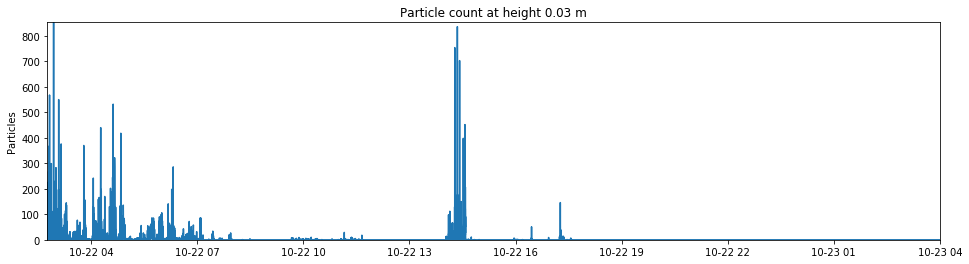

In [180]:
plt.figure(figsize=(16,4))
plt.plot(time, particle_count_1)
plt.ylabel('Particles')
plt.xlim(time[0],time[-1])
plt.ylim(0,np.max(particle_count_1))
plt.title('%s %.2f %s' %('Particle count at height', heightvalues[0], 'm'))

In [ ]:
# url = r"http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/meteohydro/meteo/meteo/meteo.nc"
# # url = "http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/meteohydro/wind/wind.nc"
# data2 = nc.Dataset(url)
# print(data2)